# ASOSAWOS Jumps Invgestigation

## Setup

In [9]:
#TODO: could use this as an alternative to multiple merges, for combining the subsets into the final output dataframe
from functools import reduce

import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import urllib
import datetime
import math
import shapely
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import scipy.stats as stats

import s3fs
import tempfile # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point
import time # Used for progress bar 
import sys # Used for progress bar 

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Warning is raised when creating Point object from coords. 

In [10]:
## Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client('s3') # for lower-level processes

## Set relative paths to other folders and objects in repository.
bucket_name = "wecc-historical-wx"
wecc_terr = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"

In [11]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary 
temp_dir = "./tmp"
if not os.path.exists(temp_dir): 
    os.mkdir(temp_dir)

In [12]:
def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.6+
    """
    Print a progress bar to console 

    References
    ----------
    https://stackoverflow.com/questions/3160699/python-progress-bar
    
    """
    count = len(it)
    start = time.time() # time estimate start
    def show(j):
        x = int(size*j/count)
        # time estimate calculation and string
        remaining = ((time.time() - start) / j) * (count - j)        
        mins, sec = divmod(remaining, 60) # limited to minutes
        time_str = f"{int(mins):02}:{sec:03.1f}"
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Est wait {time_str}", end='\r', file=out, flush=True)
    show(0.1) # avoid div/0 
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

In [13]:
def read_nc_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket 

    Parameters
    ----------
    network_name: str 
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")
    
    Returns 
    -------
    station_data: xr.Dataset 
    
    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file 
    I'd like to see us use a zarr workflow if possible to avoid this. 

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir = temp_dir, 
        prefix = "", 
        suffix = ".nc",
        delete = True
    )

    # Create s3 file system 
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    #s3_url = 's3://wecc-historical-wx/3_qaqc_wx_dev/{}/{}.nc'.format(network_name, station_id)
    s3_url = 's3://wecc-historical-wx/2_clean_wx/{}/{}.nc'.format(network_name, station_id)

    # Read in the data using xarray 
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine='h5netcdf').load()

    # Close temporary file 
    temp_file.close()

    return station_data 

In [14]:
def qaqc_ds_to_df(ds, verbose=False):
    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key,val in ds.variables.items():
        if val.dtype==object:
            if key=='station':
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)
                
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method", 
                    "pr_duration", "pr_depth", "PREC_flag",
                    "rsds_duration", "rsds_flag", 
                    "anemometer_height_m",
                    "thermometer_height_m"
                   ] # lat, lon have different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our ERA qc variable
    old_era_qc_vars = [] # our ERA qc variable

    for var in ds.data_vars:
        if 'q_code' in var: 
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var: 
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop
        if '_eraqc' in var:
            era_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)
    
    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc" # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})
                era_qc_vars.append(qc_var)
    
    print("{} created era_qc variables".format(len(era_qc_vars)-len(old_era_qc_vars)))
    if len(era_qc_vars)!=n_qc:    
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))
    
    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if 'anemometer_height_m' not in df.columns:
        try:
            df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df['anemometer_height_m'] = np.ones(len(df))*np.nan
        finally:
            pass
    if 'thermometer_height_m' not in df.columns:
        try:
            df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df['thermometer_height_m'] = np.ones(len(df))*np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()
           
    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df['station'] = station
    
    # Station pd.Series to str
    station = station.unique().values[0]
    
    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.day 
    df['month'] = pd.to_datetime(df['time']).dt.month 
    df['year'] = pd.to_datetime(df['time']).dt.year 
    df['date']  = pd.to_datetime(df['time']).dt.date
    
    return df#, MultiIndex, attrs, var_attrs, era_qc_vars 

## Load Data

In [16]:
# load in single dc file from AWS
ds_1 = read_nc_from_s3('ASOSAWOS', 'ASOSAWOS_74948400395', temp_dir) 
ds_2 = read_nc_from_s3('ASOSAWOS', 'ASOSAWOS_74509023244', temp_dir) 
ds_3 = read_nc_from_s3('ASOSAWOS', 'ASOSAWOS_72494523293', temp_dir) 

#convert to formatted pandas dataframe
df_1 = qaqc_ds_to_df(ds_1, verbose=False)
df_2 = qaqc_ds_to_df(ds_2, verbose=False)
df_3 = qaqc_ds_to_df(ds_3, verbose=False)

era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for tdps_eraqc
nans created for pr_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
nans created for ps_altimeter_eraqc
8 created era_qc variables
[]
era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for tdps_eraqc
nans created for pr_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
nans created for ps_altimeter_eraqc
nans created for psl_eraqc
9 created era_qc variables
[]
era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for tdps_eraqc
nans created for pr_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
nans created for ps_altimeter_eraqc
nans created for psl_eraqc
9 created era_qc variables
[]


## Check the 3 ASOSAWOS stations in th VEW service area

### Station 1: ASOSAWOS_74948400395

In [28]:
df_1.columns

Index(['time', 'ps', 'tas', 'tdps', 'pr', 'sfcWind', 'sfcWind_dir',
       'elevation', 'qaqc_process', 'ps_qc', 'ps_altimeter', 'ps_altimeter_qc',
       'psl_qc', 'tas_qc', 'tdps_qc', 'pr_qc', 'pr_duration', 'pr_depth_qc',
       'sfcWind_qc', 'sfcWind_method', 'sfcWind_dir_qc', 'lat', 'lon',
       'ps_eraqc', 'tas_eraqc', 'tdps_eraqc', 'pr_eraqc', 'sfcWind_eraqc',
       'sfcWind_dir_eraqc', 'elevation_eraqc', 'ps_altimeter_eraqc',
       'anemometer_height_m', 'thermometer_height_m', 'station', 'hour', 'day',
       'month', 'year', 'date'],
      dtype='object')

In [20]:
lon = df_1.lon.mean()
lat = df_1.lat.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

<built-in function id>, -121.59700, 37.08200


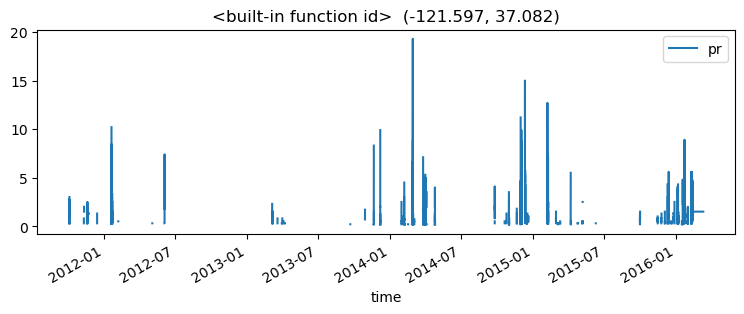

In [ ]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_1.plot(ax=ax, x="time", y="pr")
#df_1.plot(ax=ax, x="time", y="ps")
#df_1.plot(ax=ax, x="time", y="tas")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

### Station 2: ASOSAWOS_74509023244

In [29]:
df_2.columns

Index(['time', 'ps', 'tas', 'tdps', 'pr', 'sfcWind', 'sfcWind_dir',
       'elevation', 'qaqc_process', 'ps_qc', 'ps_altimeter', 'ps_altimeter_qc',
       'psl', 'psl_qc', 'tas_qc', 'tdps_qc', 'pr_qc', 'pr_duration',
       'pr_depth_qc', 'sfcWind_qc', 'sfcWind_method', 'sfcWind_dir_qc', 'lat',
       'lon', 'ps_eraqc', 'tas_eraqc', 'tdps_eraqc', 'pr_eraqc',
       'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc',
       'ps_altimeter_eraqc', 'psl_eraqc', 'anemometer_height_m',
       'thermometer_height_m', 'station', 'hour', 'day', 'month', 'year',
       'date'],
      dtype='object')

In [30]:
lon = df_2.lon.mean()
lat = df_2.lat.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

<built-in function id>, -122.04782, 37.41280


Text(0.5, 1.0, '<built-in function id>  (-121.927, 37.364)')

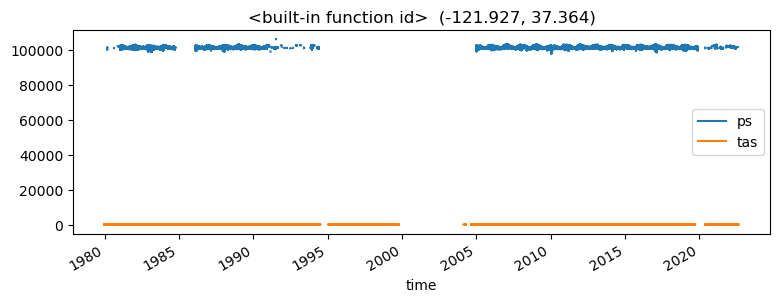

In [43]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

#df_2.plot(ax=ax, x="time", y="pr")
df_2.plot(ax=ax, x="time", y="ps")
df_2.plot(ax=ax, x="time", y="tas")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Precipitation: gap between 1986 and 1997, with two recordings in that range. 


### Station 3: ASOSAWOS_72494523293

In [35]:
df_3.columns

Index(['time', 'ps', 'tas', 'tdps', 'pr', 'sfcWind', 'sfcWind_dir',
       'elevation', 'qaqc_process', 'ps_qc', 'ps_altimeter', 'ps_altimeter_qc',
       'psl', 'psl_qc', 'tas_qc', 'tdps_qc', 'pr_qc', 'pr_duration',
       'pr_depth_qc', 'sfcWind_qc', 'sfcWind_method', 'sfcWind_dir_qc', 'lat',
       'lon', 'ps_eraqc', 'tas_eraqc', 'tdps_eraqc', 'pr_eraqc',
       'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc',
       'ps_altimeter_eraqc', 'psl_eraqc', 'anemometer_height_m',
       'thermometer_height_m', 'station', 'hour', 'day', 'month', 'year',
       'date'],
      dtype='object')

In [34]:
lon = df_3.lon.mean()
lat = df_3.lat.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

<built-in function id>, -121.92723, 37.36429


Text(0.5, 1.0, '<built-in function id>  (-121.927, 37.364)')

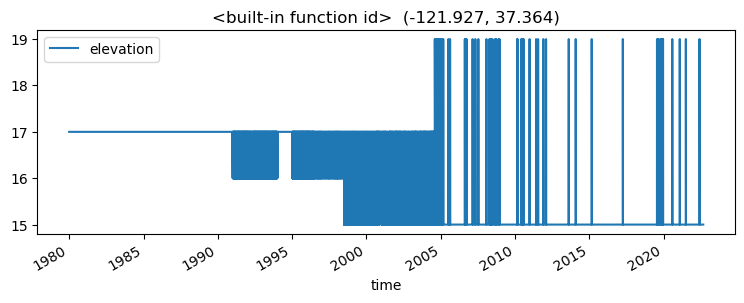

In [42]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_3.plot(ax=ax, x="time", y="elevation")
#df_3.plot(ax=ax, x="time", y="ps")
#df_3.plot(ax=ax, x="time", y="tas")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Precipitation (pr): gap from around 1986 to around 1998
Air pressure (ps):  data started being recorded in around 2005
All other meteorological variables are recorded near constantly across time.